# TUTORIAL: 
# Data assimilation using real experimental data

We can now put everything we have learned together. 

We can investigate two scenarios:

A) Assume that we have access to the post-processed data and assimilate it. This situation simplifies the problem as the experimental data is not biased (see tutorial TA_azimuthal_data to see how the raw data is biased).
-   Truth: post-processed data 
-   Observations: post-processed data + noise (possibly coloured noise)

B) Assume a realistic setting in which the post-processed data is not available on the fly to input to the data assimilation algorithm. Here, we need to address the issue of biased observations.
-   Truth: post-processed data
-   Observations: raw data

In this tutorial we will work with option A. For option B go to the tutorial ```TA_azimuthal_DA_raw.ipynb```.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from essentials.physical_models import Annular
from essentials.bias_models import ESN
import scipy.io as sio

rng = np.random.default_rng(0)


if os.path.isdir('/mscott/'):
    data_folder = '/mscott/an553/data/'  # set working directory to 
else:
    data_folder = "../data/"

## 1. Load data 
Create the reference truth and the observations.

*The code below can be compacted with the function ```create_truth```, which outputs a dictionary:*
```
  
from essentials.create import create_truth
truth = create_truth(filename, t_start, t_stop, dt_obs, post_processed=True)
```

In [2]:
ER = 0.5625
filename = data_folder + 'annular/ER_{}'.format(ER)

# Load experimental data
mat = sio.loadmat(filename + '.mat')
y_true, t_true = [mat[key].squeeze() for key in ['y_filtered', 't']]
Nt, Nq = y_true.shape
dt_t = t_true[1] - t_true[0]

# Add noise to the truth to "create" the observations
std_obs = 0.01
noise = rng.multivariate_normal(np.zeros(Nq), np.eye(Nq) * std_obs ** 2, Nt)
y_raw = y_true + noise * np.mean(abs(y_true))

# Select the observations time-window
t_start = Annular.t_transient + 1.
t_stop = t_start + 0.1
dt_obs = 50

# Sample the observations
obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + 1, dt_obs, dtype=int)
y_obs, t_obs = [xx[obs_idx] for xx in [y_raw, t_true]]

truth = dict(y_raw=y_raw, y_true=y_true, t=t_true, dt=dt_t,
             t_obs=t_true[obs_idx], y_obs=y_raw[obs_idx], dt_obs=dt_obs * dt_t,
             name=filename, noise_type='Gaussian, additive', std_obs=std_obs)


## 2. Define the forecast model
This is the physical model which we will use to model the true data.
Here, we select the filter parameters and create ensemble

*The code below can be compacted as*
```
from essentials.create import create_ensemble
ensemble = create_ensemble(model=Annular, **filter_params)
```

In [3]:
alpha0 = dict(nu=(40., 50.),
              c2beta=(5, 20),
              kappa=(1.E-4, 1.3E-4),
              epsilon=(0.0001, 0.03),
              omega=(1090 * 2 * np.pi, 1100 * 2 * np.pi),
              theta_b=(0.5, 0.7),
              theta_e=(0.5, 0.8)
              )

alpha0_mean = dict()
for alpha, lims in alpha0.items():
    alpha0_mean[alpha] = 0.5 * (lims[0] + lims[1])

ensemble = Annular(**alpha0_mean)

filter_params = {'m': 10, 
                 'inflation': 1.002,
                 'std_psi': 0.3,
                 'std_a': alpha0}

# Forecast model to initialise the ensemble after transient
state, t_ = ensemble.time_integrate(int(ensemble.t_CR / ensemble.dt))
ensemble.update_history(state[-1], reset=True)

ensemble.init_ensemble(**filter_params)



Visualize ensemble initialization

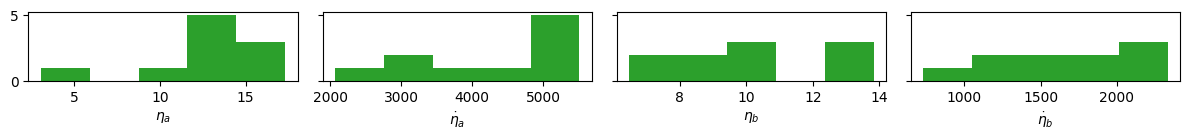

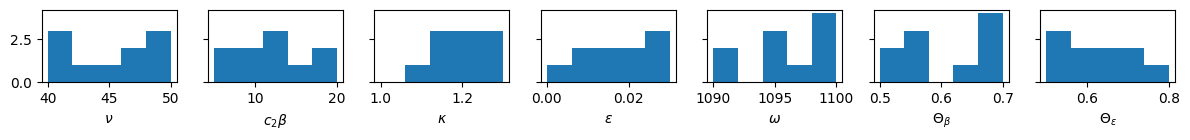

In [4]:
fig, axs = plt.subplots(figsize=(12, 1.5), layout='tight', nrows=1, ncols=ensemble.Nphi, sharey=True)
labels = ['$\eta_{a}$', '$\dot{\eta}_{a}$', '$\eta_{b}$', '$\dot{\eta}_{b}$']
for ax, ph, lbl in zip(axs.ravel(), ensemble.get_current_state[:-ensemble.Na, ], labels):
    ax.hist(ph, bins=5, color='tab:green')
    ax.set(xlabel=lbl)
fig, axs = plt.subplots(figsize=(12, 1.5), layout='tight', nrows=1, ncols=ensemble.Na, sharey=True)
reference_alpha = dict()
for param in ensemble.est_a:
    reference_alpha[param] = 1.
reference_alpha['kappa'],reference_alpha['omega']  = 1.E-4, 2 * np.pi
for ax, a, param in zip(axs.ravel(), ensemble.get_current_state[-ensemble.Na:, ], ensemble.est_a):
    xlims = np.array(ensemble.std_a[param])/reference_alpha[param]
    ax.hist(a / reference_alpha[param], bins=np.linspace(*xlims, 6))
    ax.set(xlabel=ensemble.params_labels[param])

## 4. Train an ESN to model the model bias
The procedure is the following
1) Initialise ESN Bias class object
2) Create synthetic bias to use as training data 
3) Train the ESN
4) Create washout data

The details of the code inside ```create_bias_training_dataset()``` function is explained in the tutorial ```Class_Bias.ipynb```.


In [18]:


train_params = dict(upsample=5,
                 N_units=100,
                 N_wash=5,
                 # Training data generation options
                 augment_data=True,
                 L=10,
                 # Hyperparameter search ranges
                 rho_range=(0.5, 1.1),
                 sigma_in_range=(np.log10(1e-5), np.log10(1e1)),
                 tikh_range=[1e-16]
                 )

train_data = create_bias_training_dataset(y_raw, y_true, ensemble, **train_params)



In [19]:

# TODO: ONCE TRAIN DATA CREATED, TRAIN ESN

ensemble.init_bias(**train_params)
ensemble.bias.train_bias_model(train_data=train_data,
                               plot_training=True)

AttributeError: 'NoBias' object has no attribute 'train_bias_model'

In [ ]:




#  Define the minimum length of the training set
len_train_data = train_params['t_train'] + train_params['t_val']
if train_params['perform_test']:
    len_train_data += train_params['t_test'] * 5

train_params['len_train_data'] = (int(round(len_train_data / ensemble.dt / train_params['upsample']))
                                  + train_params['N_wash'])


# Run bias model training

print(train_data['data'].shape)

train_params['y0'] = np.zeros((train_data['data'].shape[-1], 1))

ensemble.init_bias(**train_params)
ensemble.bias.filename = bias_name
ensemble.bias.train_bias_model(train_data=train_data,
                               folder=bias_model_folder,
                               plot_training=True)

ensemble.bias.print_bias_parameters()


if not hasattr(ensemble.bias, 't_init'):
    ensemble.bias.t_init = truth['t_obs'][0] - 2 * truth['dt_obs']

# Ensure the truth has washout if needed
if hasattr(ensemble.bias, 'N_wash') and 'wash_t' not in truth.keys():

    i1 = np.argmin(abs(ensemble.bias.t_init - truth['t']))
    i0 = i1 - ensemble.bias.N_wash * ensemble.bias.upsample

    if i0 < 0:
        raise ValueError('increase bias.t_init > t_wash + dt_obs')

# Add washout to the truth
truth['wash_obs'] = truth['y_raw'][i0:i1 + 1:ensemble.bias.upsample]
truth['wash_t'] = truth['t'][i0:i1 + 1:ensemble.bias.upsample]

## 5. Apply data assimilation